<a href="https://colab.research.google.com/github/Monoxido45/Graos_de_arroz_AM/blob/main/trabalho_2_graos_arroz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# pacotes para pegar os dados da net
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2

# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.metrics import (silhouette_score, silhouette_samples, 
                             calinski_harabasz_score, davies_bouldin_score,
                             adjusted_rand_score, v_measure_score)

Montando o drive para armazenar as imagens e importar os dados:

In [58]:
from google.colab import drive
drive.mount("/content/gdrive")
# path para salvar as figuras
images_dir = '/content/gdrive/MyDrive/AM_trabalhos/figuras'
#data_path = '/content/gdrive/MyDrive/AM_trabalhos/Rice_Osmancik_Cammeo_Dataset.xlsx'



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
# importando os dados
#rice_df = pd.read_excel(data_path)

link_do_arroz ='https://www.muratkoklu.com/datasets/vtdhnd03.php'
rice_df = pd.read_excel(link_do_arroz,'Rice_Osmancik_Cammeo_Dataset')
rice_df.head()

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


Checando primeiramente cada objeto do banco de dados:

In [60]:
rice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          3810 non-null   int64  
 1   PERIMETER     3810 non-null   float64
 2   MAJORAXIS     3810 non-null   float64
 3   MINORAXIS     3810 non-null   float64
 4   ECCENTRICITY  3810 non-null   float64
 5   CONVEX_AREA   3810 non-null   int64  
 6   EXTENT        3810 non-null   float64
 7   CLASS         3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


Vemos então que todos os atributos com exceção da classe são numéricos. Elencamos cada variável a seguir:  

*   **Area**: Número de pixels dentro do grão de arroz na imagem
*   **Perimeter**: Circunferência calculada a partir da distância entre os pixels localizados ao redor da borda do grão de arroz
*   **Major Axis Length**: A maior linha que pode ser desenhada no grão de arroz
*   **Minor Axis Length**: A menor linha que pode ser desenhada no grão de arroz
*   **Eccentricity**: Quão redondo é a elipse do arroz
*   **Convex Area**: Retorna a contagem de pixels da menor conxa convexa pertencente a região do grão de arroz
*   **Extent**: Retorna a razão da região formada pelo grão de arroz com relação aos pixels dentro da borda da foto
*   **Class**: Tipos de arroz: Cammeo e Osmancik

A variável Class será considerada externa ao modelo, utilizada para medidas externa de clustering. Explorando inicialmente os 7 principais atributos temos:

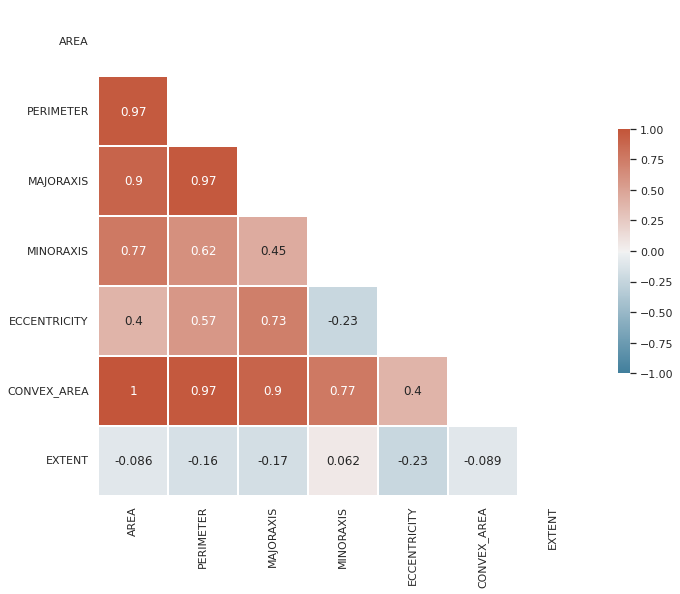

In [62]:
rice_features = rice_df.drop("CLASS", axis = 1)
cor = rice_features.corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.set_style("white")
sns.heatmap(cor, mask=mask, cmap=cmap, vmax=1, center=0, vmin = -1,
           square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.savefig(f"{images_dir}/figura_cluster/corr_matrix.pdf")
plt.show()

Vemos que a variável convex_area tem colinearidade grande com area, tendo correlação praticamente 1. Vemos que o Perimetro também tem altissima correlação com as ambas áreas. Isso não é problema aqui, pois queremos apenas analisar a estrutura dos dados a partir de agrupamentos. Podemos ver como se dá a distribuição entre cada variável a seguir:

<Figure size 720x432 with 0 Axes>

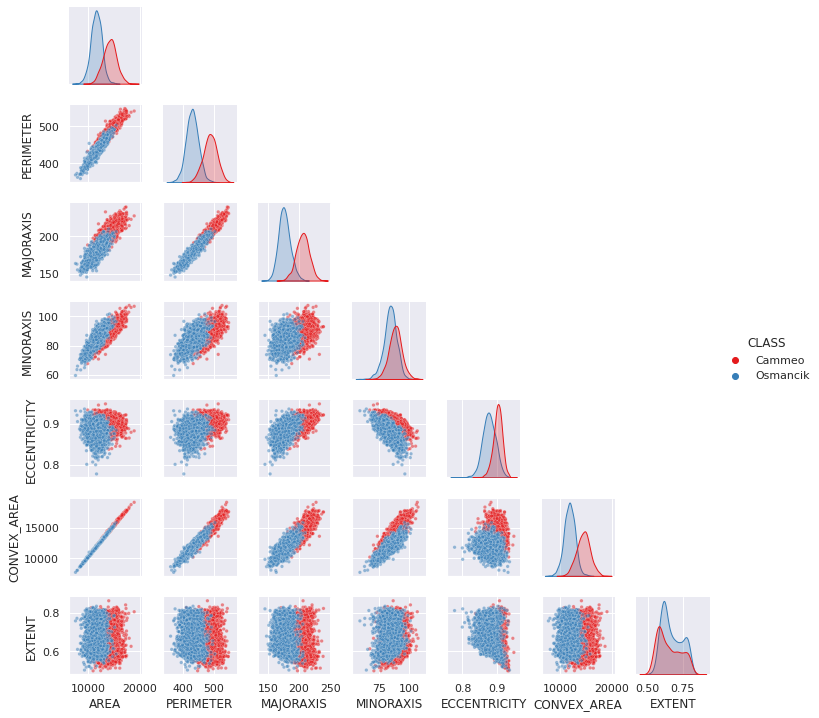

In [55]:
# setando agora a palheta e a cor da grade
sns.set_style("darkgrid")
# tirando a area convexa
plt.figure(figsize = (10, 6))

sns.pairplot(rice_df, corner = True, hue = "CLASS", height = 1.45,
             plot_kws={'alpha': 0.5, 's':12}, palette = "Set1")
plt.savefig(f"{images_dir}/figura_cluster/pair_plot.pdf")
plt.show()

In [56]:
rice_df['CLASS'].value_counts()

Osmancik    2180
Cammeo      1630
Name: CLASS, dtype: int64

<Figure size 576x432 with 0 Axes>

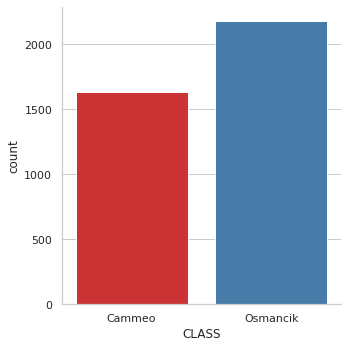

In [32]:
# grafico de barras ilustrando
sns.set_style("whitegrid")
plt.figure(figsize = (8, 6))
sns.catplot(x="CLASS", kind="count", palette="Set1", data = rice_df)
plt.savefig(f"{images_dir}/figura_cluster/class_barplot.pdf")
plt.show()

Utilizaremos para avaliar cada clustering diferentes medidas de avaliação externas, internas e relativas. Utilizaremos o indice de rand ajustado (ARI) e a medida V (V-measure) como medidas que requerem ground truth. Para medidas de validação relativa, podemos usar a silhueta média, indice de Dunn (davies_bouldin) e indice de Calinz-Harabaz.

# Cluster Hierárquico

Consideraremos os métodos de cluster aglomerativo, tendo três principais ligações de interesse: single, average e complete, juntamente também com o método de ward para construir os diferentes dendrogramas. Assim, computamos o dendrograma para cada uma das ligações:

In [63]:
# para plotar usaremos o scipy
from scipy.cluster.hierarchy import dendrogram, linkage
single = linkage(rice_features, 'single')

# listas dos tipos de linkages
link_methods = ['single', 'complete', 'average', 'ward']
clusters_dend = []

# escalonando os dados
from sklearn.preprocessing import StandardScaler
rice_standard = StandardScaler().fit_transform(rice_features)
for link in link_methods:
  clusters_dend.append(linkage(rice_standard, link))

Plotando os dendrogramas lado a lado:

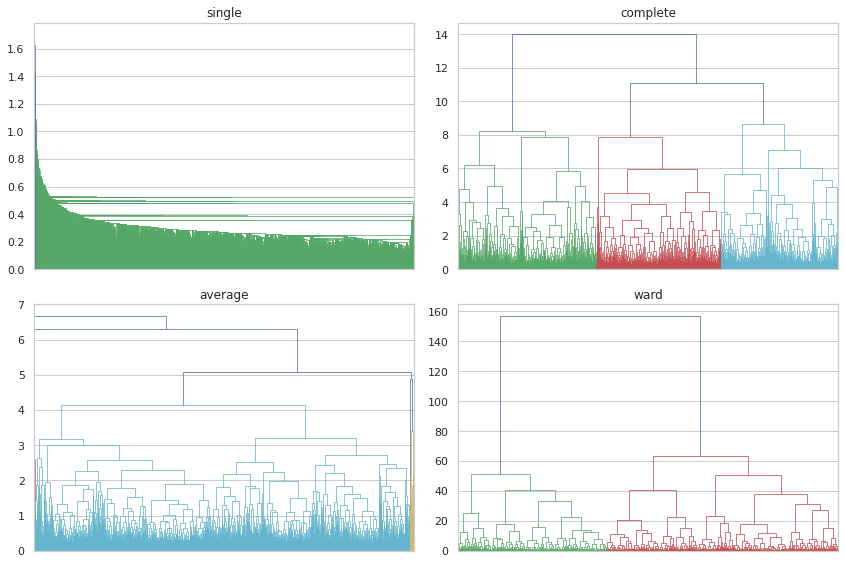

In [65]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
import sys
sys.setrecursionlimit(10000)
sns.set_style("whitegrid")
for dend, ax, link_name in zip(clusters_dend, axes.flat, link_methods):
  with plt.rc_context({'lines.linewidth': 0.75}):
    dendrogram(dend,
             orientation = 'top',
             distance_sort = 'descending',
             show_leaf_counts = False,
             no_labels = True,
             ax = ax)
    ax.set_title(link_name)
plt.tight_layout()
plt.savefig(f"{images_dir}/figura_cluster/dendrogramas.pdf")

Vemos uma maior regularidade de dendrograma nas ligações average, ward e complete, tendo possivelmente sugestões de 4 grupos no average e 2 no ward e 3 no complete. Pela irregularidade do dendrograma single, o descartaremos logo de cara. Podemos a seguir avaliar por medidas externas os 3 métodos de cluster hierarquico:

In [66]:
from sklearn.cluster import AgglomerativeClustering
# diferentes particoes fixadas
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# dicionario para os labels de cada linkage
complete_dict, average_dict, ward_dict = dict(), dict(), dict()
for clust in range_n_clusters:
  complete_dict[clust] = AgglomerativeClustering(n_clusters = clust,
                                      linkage = 'complete').fit(rice_standard).labels_
  average_dict[clust] = AgglomerativeClustering(n_clusters = clust,
                                      linkage = 'average').fit(rice_standard).labels_
  ward_dict[clust] = AgglomerativeClustering(n_clusters = clust,
                                      linkage = 'ward').fit(rice_standard).labels_

Atribuindo mesmo peso para homogeneidade e completeza na V-measure

In [67]:
# ajustando o indice de rand ajustado e v-measure
from sklearn.metrics import adjusted_rand_score, v_measure_score
ARI_list, V_measure = [], []

# ground truth
label_true = (rice_df['CLASS'] == "Cammeo").astype(int).values
# predicao do label para cada clustering
for method in [complete_dict[2], average_dict[2], ward_dict[2]]:
  ARI_list.append(adjusted_rand_score(label_true,
                                      method))
  V_measure.append(v_measure_score(label_true,
                                   method))

Assim, em uma tabela, obtemos:

In [68]:
extern_measures = pd.DataFrame(data = {'linkages':["complete", "average", "ward"],
                                       'ARI':ARI_list,
                                       'V_measure':V_measure})
extern_measures

#print(pd.DataFrame(extern_measures).to_latex())

,linkages,ARI,V_measure
0,complete,0.321393,0.240527
1,average,-0.000264,0.000853
2,ward,0.622834,0.514483


Vemos pelos scores que o average e ward tem bons scores internos em comparação ao complete. A seguir podemos ainda fazer scores relativos, variando os diversos k:

In [69]:
# instalando o vclust para calcular o dunn
!pip install validclust
from validclust import dunn
from sklearn.metrics import pairwise_distances
from sklearn.metrics import (silhouette_score, silhouette_samples, 
                            calinski_harabasz_score, davies_bouldin_score)

dist = pairwise_distances(rice_standard)
# lista para as medidas
silhouette_list, chs_list, davies_bouldin_list, dunn_list = [], [], [], []
# lista para nomes e k
names_list, k_list = [], []
for k in range_n_clusters:
  # silhueta
  sil_complete = silhouette_score(rice_standard, complete_dict[k],
                                  random_state = 125)
  sil_average = silhouette_score(rice_standard, average_dict[k], 
                                  random_state = 125)
  sil_ward = silhouette_score(rice_standard, ward_dict[k], 
                                  random_state = 125)
  # calinski_harabasz
  chs_average = calinski_harabasz_score(rice_standard, average_dict[k])
  chs_ward = calinski_harabasz_score(rice_standard, ward_dict[k])
  chs_complete = calinski_harabasz_score(rice_standard, 
                                         complete_dict[k])
  
  # davies_bouldin
  davies_bouldin_average = davies_bouldin_score(rice_standard, average_dict[k])
  davies_bouldin_ward = davies_bouldin_score(rice_standard, ward_dict[k])
  davies_bouldin_complete = davies_bouldin_score(rice_standard, 
                                         complete_dict[k])
  
  # dunn
  dunn_average = dunn(dist, average_dict[k])
  dunn_ward = dunn(dist, ward_dict[k])
  dunn_complete = dunn(dist, complete_dict[k])

  # adicionando a todas as listas
  silhouette_list.extend([sil_complete, sil_average,
                         sil_ward])
  chs_list.extend([chs_complete, chs_average,
                         chs_ward])
  davies_bouldin_list.extend([davies_bouldin_complete, davies_bouldin_average,
                         davies_bouldin_ward])
  dunn_list.extend([dunn_complete, dunn_average,
                         dunn_ward])
  # nomes dos metodos e k usado
  names_list.extend(["complete", "average", "ward"])
  k_list.extend(list(np.repeat(k, 3)))

Formatando como data frame para depois plotar tudo:

In [70]:
hclust_measures = pd.DataFrame(data = {'metodo':names_list,
                                       'k':k_list,
                                       'silhueta':silhouette_list,
                                       'chs':chs_list,
                                       'davies bouldin':davies_bouldin_list,
                                       'dunn':dunn_list})
hclust_measures.head()

,metodo,k,silhueta,chs,davies bouldin,dunn
0,complete,2,0.326935,2297.267183,1.144668,0.012447
1,average,2,0.466099,10.981671,0.613836,0.116892
2,ward,2,0.395461,3264.753848,0.965580,0.014859
3,complete,3,0.194645,1505.687555,1.751639,0.015986
4,average,3,0.315222,23.368563,0.600469,0.051844


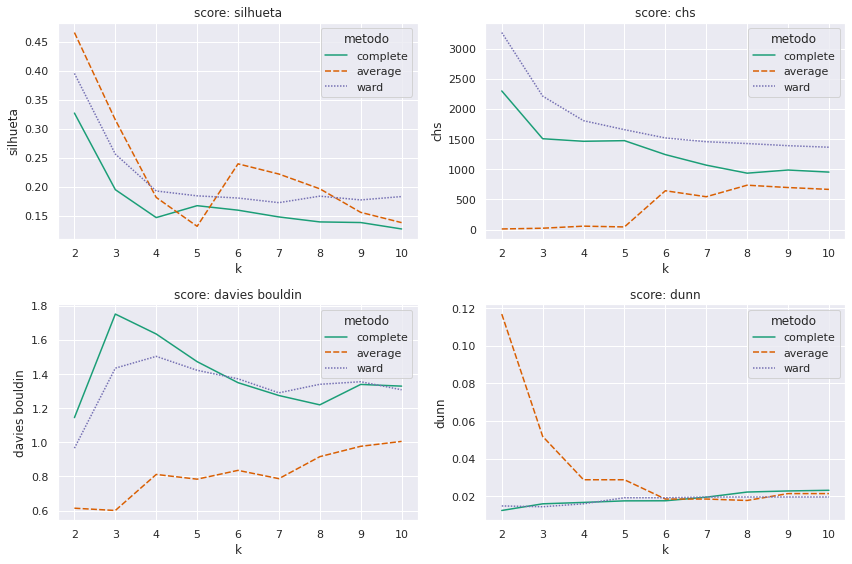

In [82]:
# plotando os diferentes k's
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
sns.set_style("darkgrid")
sns.set_palette("Dark2")
for ax, score in zip(axes.flat, ["silhueta", "chs", "davies bouldin","dunn"]):
  sns.lineplot(data = hclust_measures,
               x = "k", y = score, ax = ax,
               hue = "metodo", style = "metodo")
  ax.set_title("score: {}".format(score))


plt.tight_layout()
plt.savefig(f"{images_dir}/figura_cluster/scores_relativos_hclust.pdf")
plt.show()

Vemos melhores medidas do average na silhueta e no dunn em comparação aos demais métodos, porém, o average possui um CHS muito baixo, e um dendrograma muito irregular (provavelmente devido a um outlier). O ward possui medidas balanceadas em todos os scores, sendo o melhor no CHS (é esperado pela forma como o ward funciona), tendo um dendrograma bem regular. Assim, selecionaremos o ward como método para cluster hierarquico. Quanto a $k$, vemos que $k = 2$ em geral nos dá bons scores nos diferentes métodos. Podemos também optar segundamente por $k = 3$ e $k = 4$, já que esses números parecem desempenhar bem nos scores também. Em particular, podemos analisar o gráfico de silhueta para cada $k$ e checar como se distribui a silhueta em cada agrupamento:

# K-means

Podemos para o k-means ajustar várias partições, com o número de clusters indo de 2 a 10. Além disso, também ajustaremos o Mini-Batch K-means

In [83]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# salvando as distorcoes
distortions = []
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# dicionario para cada linkage
kmeans_dict, minibatch_kmeans_dict = dict(), dict()
for clust in range_n_clusters:
  kmeans_model = KMeans(n_clusters = clust,
                            random_state=25).fit(rice_standard)
  kmeans_dict[clust] = kmeans_model.labels_
  distortions.append(kmeans_model.inertia_)

Plotando as diferentes distorções por cada valor de $k$, incluindo $k = 1$, obtemos o gráfico de cotovelo.

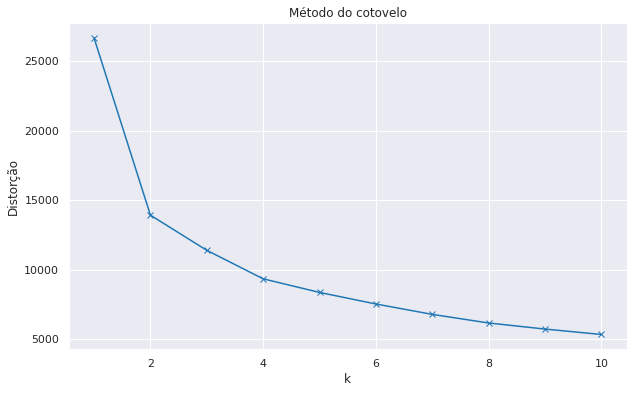

In [84]:
plt.figure(figsize=(10,6))
plt.plot(range_n_clusters, distortions, 'bx-', c = "tab:blue")
plt.xlabel('k')
plt.ylabel('Distorção')
plt.title('Método do cotovelo')
plt.savefig(f"{images_dir}/figura_cluster/cotovelo_k_means.pdf")
plt.show()

Portanto, vemos que o número ótimo de clusters pelo cotovelo seria $k = 4$, embora o ponto de inflexão no gráfico não seja tão acentuado. Sendo assim, $k = 4$ pode ser um bom chute para $k$. Podemos ainda averiguar ainda outras medidas. Tomando $k = 2$, temos as medidas internas:

In [85]:
# ground truth
label_true = (rice_df['CLASS'] == "Cammeo").astype(int).values
# predicao do label para cada clustering

ARI_value = [adjusted_rand_score(label_true,
                                      kmeans_dict[2])]
V_measure_value = [v_measure_score(label_true,
                                   kmeans_dict[2])]                              

extern_measures = pd.DataFrame(data = {'metodo':"K-means",
                                       'ARI':ARI_value,
                                       'V_measure':V_measure_value})
extern_measures

print(extern_measures.to_latex())

\begin{tabular}{llrr}
\toprule
{} &   metodo &       ARI &  V\_measure \\
\midrule
0 &  K-means &  0.681539 &   0.568509 \\
\bottomrule
\end{tabular}



Vemos um alto valor em ambos scores.

Em seguida, podemos calcular as medidas relativas:

In [86]:
# lista para as medidas
silhouette_list, chs_list, davies_bouldin_list, dunn_list = [], [], [], []

# lista para nomes e k
names_list, k_list = [], []
other_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in other_range:
  # silhueta
  sil_km = silhouette_score(rice_standard, kmeans_dict[k], 
                                  random_state = 25)
  # calinski_harabasz
  chs_km = calinski_harabasz_score(rice_standard, kmeans_dict[k])

  # davies_bouldin
  davies_bouldin_km = davies_bouldin_score(rice_standard, kmeans_dict[k])

  # dunn
  dunn_km = dunn(dist, average_dict[k])

  # adicionando a todas as listas
  silhouette_list.append(sil_km)
  chs_list.append(chs_km)
  davies_bouldin_list.append(davies_bouldin_km)
  dunn_list.append(dunn_km)
  # nomes dos metodos e k usado
  names_list.append("kmeans")
  k_list.append(k)

# para o k = 4
# silhueta
# sil = silhouette_score(rice_standard, km.labels_, random_state=25)

# calinski_harabasz
# chs = calinski_harabasz_score(rice_standard, km.labels_)

# davies_bouldin
# dunn = davies_bouldin_score(rice_standard, km.labels_)
#
# print(tabulate([['Silhueta', sil], ['Calinski-Harabasz', chs], ['Davies-Bouldin', dunn]]))

In [87]:
kmeans_measures = pd.DataFrame(data = {'metodo':names_list,
                                       'k':k_list,
                                       'silhueta':silhouette_list,
                                       'chs':chs_list,
                                       'dunn':dunn_list,
                                       'davies bouldin':davies_bouldin_list})
kmeans_measures.head()

,metodo,k,silhueta,chs,dunn,davies bouldin
0,kmeans,2,0.409961,3483.328260,0.116892,0.951224
1,kmeans,3,0.308740,2549.084346,0.051844,1.247704
2,kmeans,4,0.270808,2349.059182,0.028787,1.226316
3,kmeans,5,0.264025,2078.034013,0.028787,1.237279
4,kmeans,6,0.264029,1929.315028,0.018533,1.225474


Plotando:

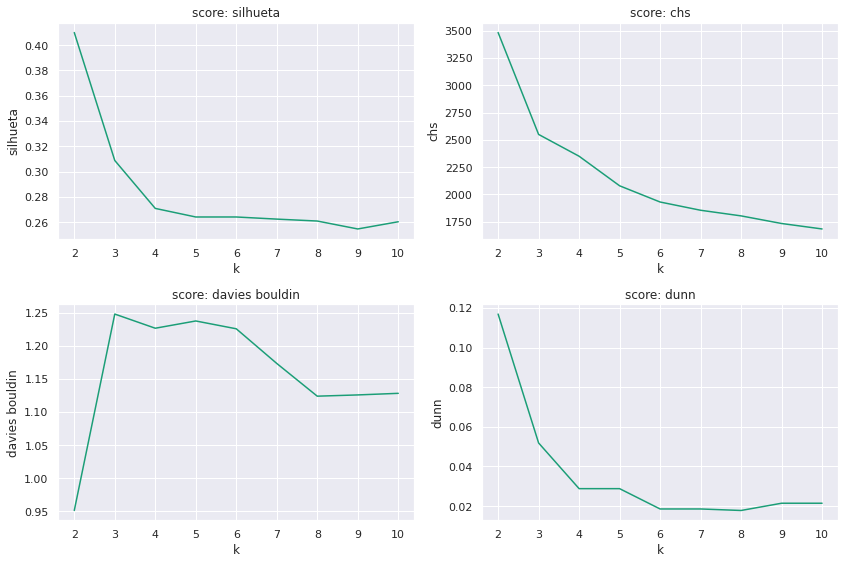

In [88]:
# plotando os diferentes k's
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
sns.set_style("darkgrid")
for ax, score in zip(axes.flat, ["silhueta", "chs", "davies bouldin", "dunn"]):
  sns.lineplot(data = kmeans_measures,
               x = "k", y = score, ax = ax, ci = None, )
  ax.set_title("score: {}".format(score))
  
plt.tight_layout()
plt.savefig(f"{images_dir}/figura_cluster/scores_relativos_kmeans.pdf")
plt.show()

# Dbscan

In [80]:
link_do_arroz ='https://www.muratkoklu.com/datasets/vtdhnd03.php'
rice_df = pd.read_excel(link_do_arroz,'Rice_Osmancik_Cammeo_Dataset')
rice_features = rice_df.drop("CLASS", axis = 1)

### Normalizando os dados
rice_standard = StandardScaler().fit_transform(rice_features)

#### DBSCan 1 - Hiperparâmetros iniciais 


Para o número mínimo de observações ($minPts$), será considerado um $2*dim$, em que $dim$ é o número de colunas/variáveis. Tal sugestão é encontrada em [(Sander et al., 1998)](https://stackoverflow.com/a/54115075)


In [81]:
print("O número mínimo de pontos na vizinha para considerar um p como ponto é: {}".format(2*rice_standard.shape[1]))

O número mínimo de pontos na vizinha para considerar um p como ponto é: 14


Escolhido o número mínimo de pontos na vizinha, fixa-se ele e busca-se encontrar o valor de $ϵ$ (distância máxima da vizinhança). Para isso se faz um gráfico da distância do k-vizinho mais próximo contra os pontos ordenados de forma crescente pela própria distância. Nesse kaso, k=($minPts$) já escolhido anteriormente. Essa sugestão também é encontrada em [(Sander et al., 1998)](https://stackoverflow.com/a/54115075)

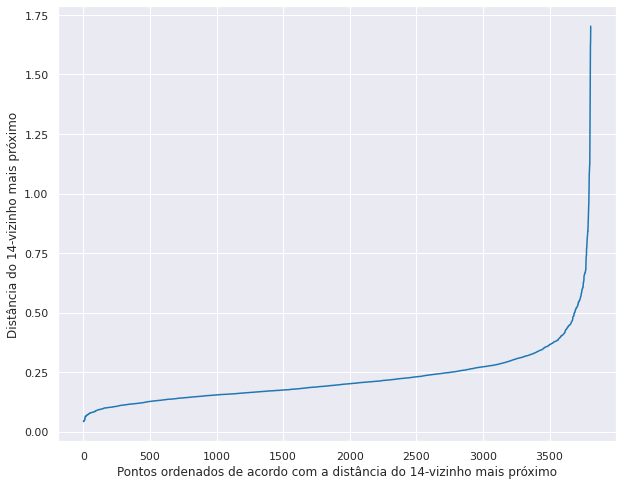

In [90]:
### Definindo o k de k-vizinho 
vizinhos = NearestNeighbors(n_neighbors=2*rice_standard.shape[1],
                            p=2,metric='minkowski')

## Lembrando que p=2 e metric='minkowski'
# equivale a distancia euclidicana.

### Encontrado as distancias para o banco de dados
vizinhos_ajuste = vizinhos.fit(rice_standard)
dist, indi = vizinhos_ajuste.kneighbors(rice_standard)
### Ordenando os pontos
dist = np.sort(dist, axis=0)
dist = dist[:,1]

### Plotando o grafico 
sns.set_style("darkgrid")
plt.figure(figsize = (10, 8))
plt.plot(dist, color = "tab:blue")
plt.xlabel("Pontos ordenados de acordo com a distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
plt.ylabel("Distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
#plt.savefig(f"{images_dir}/figura_cluster/dbscan_cotovelo_14_vizinhos.pdf")
plt.show()


Observando o Figura anterior, percebe-se que a distância ideal ser considerar é em torno de 0.4, onde está o cotovelo do gráfico.

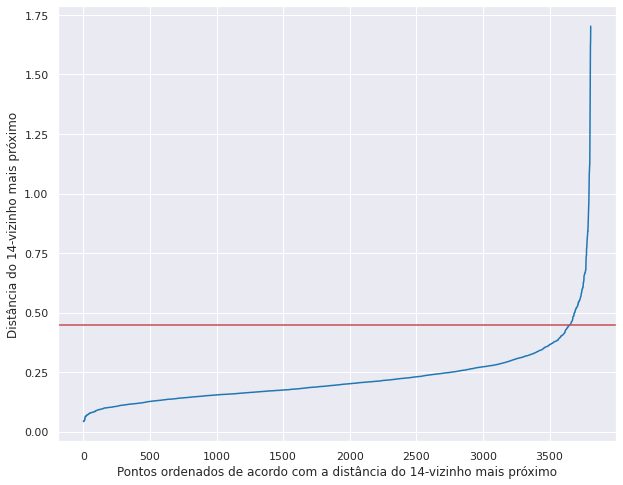

In [92]:
### Plotando o grafico 
sns.set_style("darkgrid")
plt.figure(figsize = (10, 8))
plt.plot(dist, color = "tab:blue")
plt.axhline(y = 0.45, color = 'r', linestyle = '-')
plt.xlabel("Pontos ordenados de acordo com a distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
plt.ylabel("Distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
#plt.savefig(f"{images_dir}/figura_cluster/dbscan_cotovelo_14_vizinhos.pdf")
plt.show()

In [93]:
print("O minPts do dbscan é {}.".format(2*rice_standard.shape[1]))
print("A distância epsilon do dbscan é {}.".format(0.4))

O minPts do dbscan é 14.
A distância epsilon do dbscan é 0.4.


Encontrado os hiperparâmetros, basta ajustar o DBScan.

In [94]:
### Ajustando o DBScan
dbscan_rice = DBSCAN(min_samples=2*rice_standard.shape[1],eps=0.4).fit(rice_standard)

# Verdadeiro rotulo
label_true = (rice_df['CLASS'] == "Cammeo").astype(int).values

# Rotulo do dbscan
modifica_rotulo_dbs = np.zeros_like(dbscan_rice.labels_, dtype=bool)
modifica_rotulo_dbs[dbscan_rice.core_sample_indices_] = True
label_dbscan = dbscan_rice.labels_

# Numero de cluseters e de ruidos (se presente)
n_clusters_dbscan = len(set(label_dbscan)) - (1 if -1 in label_dbscan else 0)
n_noise_dbscan = list(label_dbscan).count(-1)

print('Número de clusters no DBSCan: {}'.format(n_clusters_dbscan))
print('Número de ruídos no DBSCan: {}'.format(n_noise_dbscan))

Número de clusters no DBSCan: 9
Número de ruídos no DBSCan: 1778


Nota-se que o DBScan deixou muitas observações (ruídos) de fora de clusters. Além de encontrar 9 cluters, um número alto uma vez que há somente 2 tipos de arroz. Sendo assim, pode-se testar outros valores no DBSCan para melhorar isso.

#### DBSCan 2 - Outros hiperparâmetros

Dado que o primeiro DBSCan não obteve valores bons (grande número de grupos e muitos ruídos), pode-se escolher outros valores para para $minPts$ e $ϵ$. 

Dessa forma, optou-se diminuir o número de pontos mínimos para 12, uma vez que o banco de dados não é relativamente grande e aumentar um pouco o $ϵ$ para 0.5, pois queremos englobar um pouco as observações.

In [95]:
### Ajustando o DBScan
dbscan2_rice = DBSCAN(min_samples=12,eps=0.5).fit(rice_standard)

# Verdadeiro rotulo
label_true = (rice_df['CLASS'] == "Cammeo").astype(int).values

# Rotulo do dbscan
modifica_rotulo_dbs = np.zeros_like(dbscan2_rice.labels_, dtype=bool)
modifica_rotulo_dbs[dbscan2_rice.core_sample_indices_] = True
label_dbscan2 = dbscan2_rice.labels_

# Numero de cluseters e de ruidos (se presente)
n_clusters_dbscan2 = len(set(label_dbscan2)) - (1 if -1 in label_dbscan2 else 0)
n_noise_dbscan2 = list(label_dbscan2).count(-1)

print('Número de clusters no DBSCan2: {}'.format(n_clusters_dbscan2))
print('Número de ruídos no DBSCan2: {}'.format(n_noise_dbscan2))


Número de clusters no DBSCan2: 2
Número de ruídos no DBSCan2: 564


Nota-se que os valores já ficaram bem melhores do que na situação 1 anterior. 

Contudo, em uma situação de real de aprendizado de máquina não supervisionado, em que não tivéssemos ideia nenhuma dos grupos, não seria possível chutar novos valores assim para $minPts$ e $ϵ$. 

#### DBScan - Críterios relativos

$\quad$ Dado que o DBSCan utiliza-se do conceito de densidade para criar os clusters, o conceito de ruído também está presente, isto é, há pontos que não pertencem em nenhuma classificação. 

$\quad$ Desse modo, utiliza-se um critério especial para técnicas de agrupamentos baseado em densidade, que é o [CDbw](https://sci-hub.se/10.1016/j.patrec.2007.12.011) (density-based cluster validity approach using multi-representatives). Quanto maior essa medida, melhor o agrupamento formado.

In [96]:
!pip install cdbw
from cdbw import CDbw

In [97]:
print("O CBbw do DBSCan é {}".format(CDbw(rice_standard,label_dbscan, metric="euclidean")))
print("O CBbw do DBSCan2 é {}".format(CDbw(rice_standard,label_dbscan2, metric="euclidean")))

O CBbw do DBSCan é 0.18836713963268778
O CBbw do DBSCan2 é 0.013155691084011953


Mesmo usando uma informação externa e tentando obter um melhor agrupando na segunda situação do DBSCan, o primeiro caso obteve medidas maiores de avaliação.

# Cruzando as medidas de avaliação dos melhores métodos:

Podemos a seguir cruzar o cluster hierarquico com metodo ward:

In [98]:
# filtrando apenas pelo ward
all_measures = pd.concat([hclust_measures[hclust_measures.metodo == "ward"], 
                         kmeans_measures], ignore_index = True)

In [99]:
all_measures.head()

,metodo,k,silhueta,chs,davies bouldin,dunn
0,ward,2,0.395461,3264.753848,0.965580,0.014859
1,ward,3,0.256111,2211.647615,1.434683,0.014431
2,ward,4,0.192393,1804.445302,1.503743,0.016002
3,ward,5,0.184005,1655.870633,1.422101,0.019222
4,ward,6,0.180202,1518.567982,1.372144,0.019222


Plotando os diferentes $k$ para o k-means e ward:

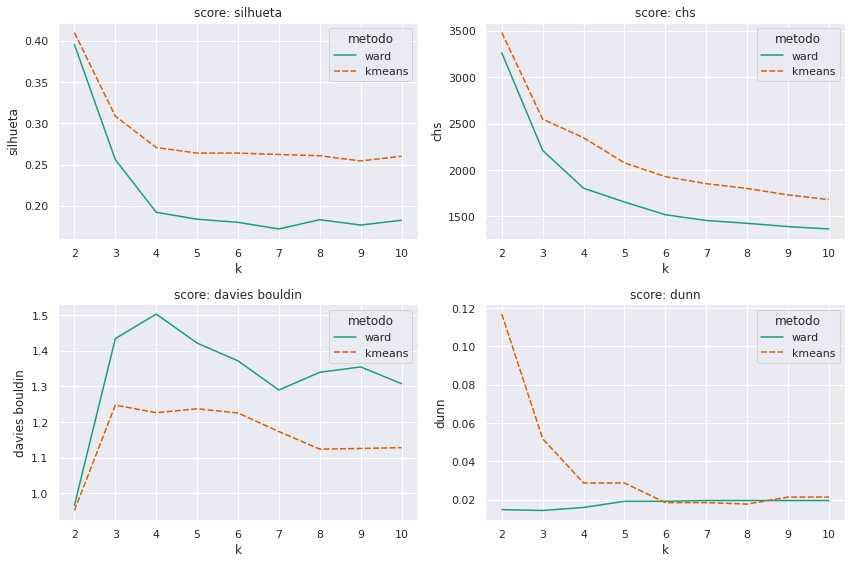

In [100]:
# plotando os diferentes k's
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
sns.set_style("darkgrid")
for ax, score in zip(axes.flat, ["silhueta", "chs", "davies bouldin", "dunn"]):
  sns.lineplot(data = all_measures,
               x = "k", y = score, ax = ax,
               hue = "metodo", style = "metodo")
  ax.set_title("score: {}".format(score))


plt.tight_layout()
plt.savefig(f"{images_dir}/figura_cluster/scores_relativos_km_hc.pdf")
plt.show()

Em geral, vemos um melhor desempenho do K-means em relação ao ward em cada score, incluindo os externos. Assim, vemos que de fato o K-means é o melhor método a ser analisado.

# Analisando os agrupamentos sugeridos:

Agora podemos analisar como se distribuem os grupos resultantes através de violinplots. Não consideraremos convex area devido a correlação perfeita desta com area.

In [101]:
rice_clust = rice_features.drop("CONVEX_AREA", axis = 1)
rice_clust = rice_clust.assign(cluster2 = kmeans_dict[2], 
                  cluster3 = kmeans_dict[3])

Plotando para $k = 2$:

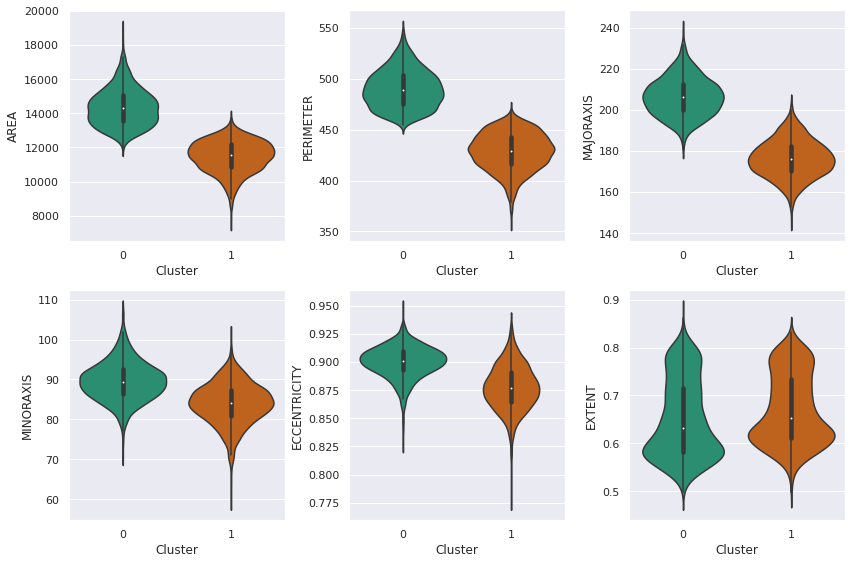

In [102]:
all_num_vars = rice_clust.select_dtypes(["int64", "float64"]).columns
sns.set_style("darkgrid")
fig, axes = plt.subplots(2, 3, figsize = (12, 8))
j = 1
for ax, variable in zip(axes.flat, all_num_vars):
  sns.violinplot(data = rice_clust, y = variable, x = "cluster2", ax = ax)
  ax.set_xlabel("Cluster")
plt.tight_layout()
plt.savefig(f"{images_dir}/figura_cluster/violinplots_clusters_2.pdf")
plt.show()

Para $k = 3$:

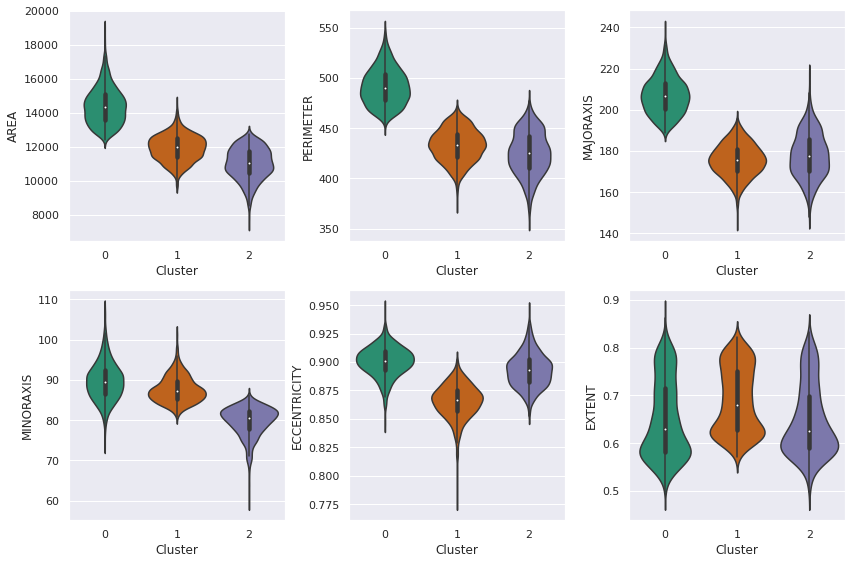

In [103]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(2, 3, figsize = (12, 8))
j = 1
for ax, variable in zip(axes.flat, all_num_vars):
  sns.violinplot(data = rice_clust, y = variable, x = "cluster3", ax = ax)
  ax.set_xlabel("Cluster")
plt.tight_layout()
plt.savefig(f"{images_dir}/figura_cluster/violinplots_clusters_3.pdf")
plt.show()

Computando a média para cada cluster no banco de dados escalonado:

In [104]:
rice_standard = rice_clust
rice_standard[all_num_vars] = StandardScaler().fit_transform(rice_standard[all_num_vars])

# plotando agora apenas as medias
# media para dois clusters
mean_cl2 = rice_standard.drop("cluster3", axis = 1).groupby("cluster2").mean()

# media para tres clusters
mean_cl3 = rice_standard.drop("cluster2", axis = 1).groupby("cluster3").mean()

In [105]:
# adicionando o indice do cluster em uma coluna separada
mean_cl2.index.name = 'cluster2'
mean_cl2.reset_index(inplace=True)

# adicionando o indice do cluster em uma coluna separada
mean_cl3.index.name = 'cluster3'
mean_cl3.reset_index(inplace=True)

Derretendo os vetores de médias:

In [106]:
mean_cl2_melt = mean_cl2.melt(id_vars = "cluster2", value_vars = all_num_vars)
mean_cl3_melt = mean_cl3.melt(id_vars = "cluster3", value_vars = all_num_vars)

In [107]:
mean_cl3_melt

,cluster3,variable,value
0,0,AREA,1.006952
1,1,AREA,-0.424950
2,2,AREA,-0.955744
3,0,PERIMETER,1.049974
4,1,PERIMETER,-0.595419
5,2,PERIMETER,-0.810679
6,0,MAJORAXIS,1.047037
7,1,MAJORAXIS,-0.752534
8,2,MAJORAXIS,-0.614620
9,0,MINORAXIS,0.591381


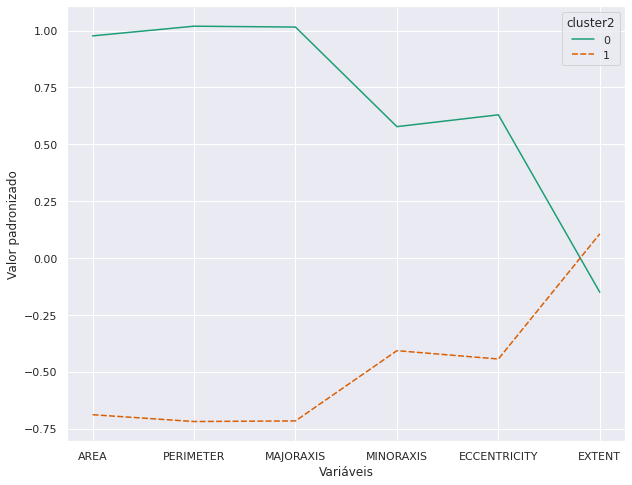

In [108]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = mean_cl2_melt, x = "variable", y = "value",
             hue = "cluster2", style = "cluster2")
plt.xlabel("Variáveis")
plt.ylabel("Valor padronizado")
plt.savefig(f"{images_dir}/figura_cluster/medias_cluster2.pdf")
plt.show()